# Movie recommender with multinomial RBM(Tensorflow, GPU)
Restricted Boltzmann Machine은 비지도 학습을 수행할 때 보통 사용되는 생성적 신경망(Generative Neural Model)입니다. RBM의 주 기능은 결합확률분포 *P(v,h)* 를 배우는 것입니다. 여기서 *v*는 입력데이터를 나타내는 visible units, *h*는 잠재 변수들을 나타내는 hidden units입니다. 결합분포가 학습되면 샘플링을 통해 새로운 예시들이 생성됩니다.   
이 notebook은 알고리즘을 사용하고 평가하는 데 필요한 기본적인 방법을 소개하고, `RBM Deep Dive section`에서 더 자세한 내용을 소개합니다.   
여기서 사용되는 RBM은 논문에서 사용된 one-hot encoded units 대신 multinomial units를 사용하였습니다.

### Advantages of RBM:
RBM은 collaborative filtering에 기반한 접근으로 user/item 쌍에 대해 ratings를 생성합니다. Matrix factorization 방법은 user/item 선호도 행렬의 인스턴스를 재현하는 방법을 학습하는 반면, RBM은 근본적인 확률 분포를 학습합니다.
- 모델이 새로운 문제에 잘 일반화되어 있습니다.
- 추천 작업이 time-stationary일 경우, 새로운 ratings/users에 적용하기 위해 모델을 새로 학습시킬 필요가 없습니다.
- 여기서 시행되는 tensorflow 작업은 GPU에서의 빠른 학습이 가능합니다.

In [1]:
import sys
import pandas as pd
import numpy as np
import scrapbook as sb
import tensorflow as tf

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

%load_ext autoreload
%autoreload 2
%matplotlib inline

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0]
Pandas version: 1.3.5
Tensorflow version: 2.7.3


### 1. Load and split the data using the stratified splitter
943 users, 1682 movies, 100k ratings
이전까지의 지도학습 모델에서는 데이터셋의 특정 비율만큼 training example로 분리하여 train/test matrix가 서로 다른 차원의 row를 가졌습니다. 이 모델에선 두 matrix가 같은 차원의 row를 갖지만, 서로 다른 양의 ratings를 보유합니다. 더 자세한 내용은 deep dive notebook에서 다룹니다.   
이 방법은 데이터셋의 sparsness와 user/affinity matrix의 사이즈에 대한 정보도 제공합니다. Sparsness의 경우 unrated elements와 전체 matrix elements 수의 비율로 주어집니다. 그런데 이 sparsness 때문에 추천 작업이 어려워지는데, 이번 작업의 경우 7%의 정보로 93%의 missing data를 예측해야 하기 때문입니다.     
`Xtrain`과 `Xtest`는 정확히 같은 차원의 행렬이지만, 명확히 구분되는 서로 다른 항목을 갖고 있음을 기억해야 합니다.

In [2]:
movielens_data_size = '100k'
data = movielens.load_pandas_df(size=movielens_data_size,
                               header=['userID','movieID','rating','timestamp'])

header = {'col_user':'userID', 'col_item':'movieID', 'col_rating':'rating'}
am = AffinityMatrix(df = data, **header)
X, _, _ = am.gen_affinity_matrix()

Xtrain, Xtest = numpy_stratified_split(X)

100%|█████████████████████████████████████| 4.81k/4.81k [00:02<00:00, 1.78kKB/s]


### 2. Train the RBM model
RBM 모델은 TF class로 구현되었습니다. TF는 확률적 모델을 지원하지 않기 때문에, 기존의 유명한 지도학습 모델들에서 봐왔던 것들과 다른 구조로 알고리즘이 시행됩니다. TF 세션이 `fit()`메소드에 숨겨져 있고 외적인 호출이 필요하지 않은 방법으로 시행됩니다.   
- Model initialization   
TF의 연산 그래프를 어떻게 설계할 지 정하는 과정입니다. Hidden unit의 수, training epoch의 수와 미니배치 사이즈를 특정합니다. 다른 변수들도 더 좋은 성능을 얻기 위해 부가적으로 변경될 수 있습니다. 이는 `RBM Deep Dive Section`에서 자세히 설명됩니다.   
- Model fit   
모델을 데이터에 훈련시키는 과정입니다. 모델은 오직 training set에만 훈련되어있고, test set은 훈련된 모델의 일반화 정확도를 보여줍니다. 이는 하이퍼 파라미터를 어떻게 조정해야 할지에 대한 아이디어를 제공하기에 유용합니다.   
- Model prediction   
모델이 본 적 없는 아이템들에 대한 예측을 생성하는 단계입니다. Once the model has been trained and we are satisfied with its overall accuracy, we sample new ratings from the learned distribution. In particular, we extract the top_k (e.g. 10) most relevant recommendations according to some predefined score. The prediction is then returned in a dataframe format ready to be analysed and deployed.   
    
fit method가 초음 호출됐을 땐 TF가 GPU 세션을 초기화하기 때문에 시간이 좀 더 걸릴 수 있습니다.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2022-06-23 15:13:19.665246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 15:13:19.668989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 15:13:19.669222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 15:13:19.670146: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Took 1.62 secs for training


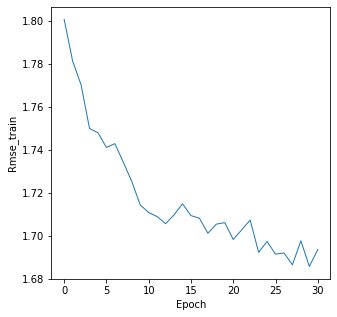

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

model = RBM(possible_ratings=np.setdiff1d(np.unique(Xtrain), np.array([0])),
           visible_units=Xtrain.shape[1], hidden_units=600,
           training_epoch=30, minibatch_size=60,
           keep_prob=0.9, with_metrics=True)

with Timer() as train_time:
    model.fit(Xtrain)
    
print("Took {:.2f} secs for training".format(train_time.interval))
line_graph(values=model.rmse_train, labels='Train', x_name='Epoch',y_name='Rmse_train')

2022-06-23 13:19:21.792400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 13:19:21.792668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 13:19:21.792846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 13:19:21.793051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 13:19:21.793253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Took 9.85 secs for training


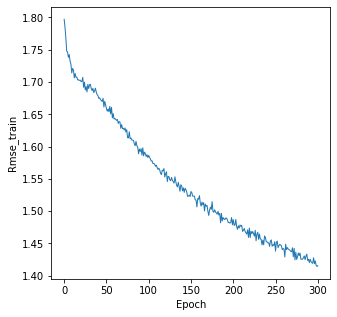

In [5]:
model2 = RBM(possible_ratings=np.setdiff1d(np.unique(Xtrain), np.array([0])),
           visible_units=Xtrain.shape[1], hidden_units=600,
           training_epoch=300, minibatch_size=60,
           keep_prob=0.9, with_metrics=True)

with Timer() as train_time:
    model2.fit(Xtrain)
    
print("Took {:.2f} secs for training".format(train_time.interval))
line_graph(values=model2.rmse_train, labels='Train', x_name='Epoch',y_name='Rmse_train')

In [4]:
# Predict new ratings on the test set
K = 10
with Timer() as prediction_time:
    top_k = model.recommend_k_items(Xtrain)

print('Took {:.2f} secs for prediction'.format(prediction_time.interval))

Took 0.13 secs for prediction


In [5]:
top_k_df = am.map_back_sparse(top_k, kind='prediction')
test_df = am.map_back_sparse(Xtest, kind='ratings')
top_k_df.head(10)

,userID,movieID,prediction
0,1,280,4.501705
1,1,331,4.271675
2,1,850,4.236463
3,1,1244,4.422591
4,1,1347,4.213525
5,1,1418,4.220323
6,1,1525,4.364691
7,1,1581,4.189180
8,1,1546,4.591193
9,1,1637,4.189841


### 3. Evaluation metrics


In [6]:
def ranking_metrics(data_size, data_true, data_pred, K):
    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)
    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", col_rating="rating", col_prediction="prediction", relevancy_method="top_k", k= K)
    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)
    
    
    df_result = pd.DataFrame({'Dataset': data_size, 'K': K, 'MAP': eval_map,
                             'nDCG@k': eval_ndcg, 'Precision@k': eval_precision,
                             'Recall@k': eval_recall}, index=[0])
    return df_result

In [7]:
eval_100k = ranking_metrics(
    data_size="mv 100k",
    data_true=test_df,
    data_pred=top_k_df,
    K=10
)

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 100k,10,0.00027,0.00435,0.00456,0.001098


In [8]:
sb.glue("map", eval_100k['MAP'][0])
sb.glue("ndcg", eval_100k['nDCG@k'][0])
sb.glue("precision", eval_100k['Precision@k'][0])
sb.glue("recall", eval_100k['Recall@k'][0])

### 4. Saving the model and Loading a pre-trained model

In [9]:
model.save(file_path='./models/rbm_model.ckpt')
# Initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtrain), np.array([0])),
    visible_units=Xtrain.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.9,
    with_metrics=True
)

# Load the model checkpoint
model.load(file_path='./models/rbm_model.ckpt')

INFO:tensorflow:Restoring parameters from models/rbm_model.ckpt


2022-06-23 15:15:03.691219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 15:15:03.691437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 15:15:03.691574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 15:15:03.691740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 15:15:03.691873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S